In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, average_precision_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import randint

### Reading Files

In [49]:
vehicles = pd.read_csv("vehpub_2017.csv")
households = pd.read_csv("hhpub_2017.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Data Pre-Processing
- Merged household data with vehicle data.
- Experimented with some trip data inputs with little success.

In [50]:
vehicles = vehicles.merge(households[['HOUSEID', 'CNTTDHH', 'CAR', 'PRICE', 'PLACE']], on='HOUSEID', how='left')

In [51]:
vehicles['VEHTYPE'] = vehicles['VEHTYPE'].replace(5, 4)
vehicles['FUELTYPE'] = vehicles['FUELTYPE'].replace(6, 4)
vehicles_df = vehicles[(vehicles['VEHTYPE'] > 0)
                      & (vehicles['VEHTYPE'] != 6)
                      & (vehicles['VEHTYPE'] != 97)
                      & (vehicles['FUELTYPE'] > 0)
                      & (vehicles['FUELTYPE'] != 97)
                      & (vehicles['VEHAGE'] < 40)
                      & (vehicles['VEHAGE'] > 0)
                      & (vehicles['HTPPOPDN'] != -9)
                      & (vehicles['URBAN'] != 4)]
vehicles_df.loc[vehicles_df['VEHTYPE'] == 1, 'VEHTYPE'] = "Automobile"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 2, 'VEHTYPE'] = "Van"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 3, 'VEHTYPE'] = "SUV"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 4, 'VEHTYPE'] = "Truck"
vehicles_df.loc[vehicles_df['VEHTYPE'] == 7, 'VEHTYPE'] = "Motorcycle"
vehicles_df.loc[vehicles_df['FUELTYPE'] == 1, 'FUELTYPE'] = "Gas"
vehicles_df.loc[vehicles_df['FUELTYPE'] == 2, 'FUELTYPE'] = "Diesel"
vehicles_df.loc[vehicles_df['FUELTYPE'] == 3, 'FUELTYPE'] = "Hybrid"
vehicles_df.head(10)

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,HFUEL,VEHOWNED,VEHOWNMO,ANNMILES,HYBRID,PERSONID,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTHHFIN,BESTMILE,BEST_FLG,BEST_EDT,BEST_OUT,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN,GSYRGAL,GSTOTCST,FEGEMPG,FEGEMPGA,GSCOST,FEGEMPGF,CNTTDHH,CAR,PRICE,PLACE
0,30000007,1,2007,10,49,49032,Gas,Automobile,3,69000,-1,1,-1,1000,2,3,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,14611.926637,1,-1,4,T,50,1500,750,750,20,750,300,487.064221,1126.457778,30,-9,2.312750,1,6,1,1,2
1,30000007,2,2004,13,49,49442,Gas,Van,-8,164000,-1,1,-1,2500,2,-8,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,4767.090946,3,-1,-1,T,50,1500,750,750,20,750,300,250.899523,580.267873,19,-9,2.312750,1,6,1,1,2
2,30000007,3,1998,19,19,19014,Gas,Automobile,1,120000,-1,1,-1,900,2,1,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,8000.324552,1,-1,-1,T,50,1500,750,750,20,750,300,444.462475,1027.930589,18,-9,2.312750,1,6,1,1,2
3,30000007,4,1997,20,19,19021,Gas,Automobile,2,-88,-1,1,-1,500,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,725.932347,2,-1,-1,T,50,1500,750,750,20,750,300,40.329575,93.272224,18,-9,2.312750,1,6,1,1,2
4,30000007,5,1993,24,20,20481,Gas,Truck,2,300000,-1,1,-1,10000,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,12437.658757,1,-1,-1,T,50,1500,750,750,20,750,300,888.404197,2054.656806,14,-9,2.312750,1,6,1,1,2
9,30000012,1,2011,6,58,58037,Gas,Automobile,1,70115,-1,1,-1,11000,2,1,5,1,1,2,10,1,NY,36,1,1,201607,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,79.419586,4616.917047,1,-1,-1,C,80,17000,17000,5000,60,17000,7000,219.853193,542.011404,21,-9,2.465333,1,9,1,2,1
10,30000012,2,2004,13,12,12473,Gas,SUV,1,68204,-1,1,-1,6000,2,1,5,1,1,2,10,1,NY,36,1,1,201607,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,79.419586,4002.551052,1,-1,-1,C,80,17000,17000,5000,60,17000,7000,250.159441,616.726408,16,-9,2.465333,1,9,1,2,1
11,30000019,1,2006,11,37,37032,Gas,Automobile,1,120000,-1,1,-1,10000,2,1,5,1,2,2,3,2,MD,24,2,0,201605,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,279.143588,7027.686033,1,-1,-1,S,40,300,300,150,50,750,300,305.551567,745.596748,23,-9,2.440167,1,4,1,2,3
12,30000019,2,1997,20,21,21001,Gas,Automobile,1,135000,-1,1,-1,5000,2,1,5,1,2,2,3,2,MD,24,2,0,201605,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,279.143588,12833.557760,1,-1,-1,S,40,300,300,150,50,750,300,641.677888,1565.800993,20,-9,2.440167,1,4,1,2,3
13,30000029,1,2016,1,49,49402,Gas,SUV,1,8774,-1,2,5,21058,2,1,3,1,2,2,5,2,WI,55,2,0,201610,10,3,3,2,1,2,1,3,2,33,1,2,XXXXX,2,103.240304,14029.079480,1,-1,-1,S,40,1500,750,750,40,1500,750,561.163179,1271.876346,25,-9,2.266500,1,10,1,3,2


### Basic Metadata

In [52]:
len(vehicles_df)

179576

In [53]:
vehicles_df['VEHTYPE'].value_counts(normalize=True)

VEHTYPE
Automobile    0.520348
SUV           0.248714
Truck         0.146200
Van           0.053610
Motorcycle    0.031129
Name: proportion, dtype: float64

In [54]:
vehicles_df['FUELTYPE'].value_counts(normalize=True)

FUELTYPE
Gas       0.952282
Hybrid    0.028913
Diesel    0.018805
Name: proportion, dtype: float64

## Predicting Vehicle Type
- Random Forest Model

### Split Data Into Training & Test Splits

In [55]:
X = vehicles_df[['CNTTDHH', 'HTPPOPDN', 'HHSIZE', 'HHVEHCNT', 'DRVRCNT']]
y = vehicles_df['VEHTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Hyperparameter Tuning
- OPTIONAL - High computational load

In [16]:
param_dist = {'n_estimators': randint(250, 750), 'max_depth': randint(50, 150)}
rfc = RandomForestClassifier(class_weight='balanced')
rand_search = RandomizedSearchCV(rfc, param_distributions = param_dist, n_iter=5, cv=5)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa4dba43520>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa4db970700>})

In [17]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:', rand_search.best_params_)

Best hyperparameters: {'max_depth': 96, 'n_estimators': 616}


### Run Model 

In [69]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train);

In [70]:
#pipeline = Pipeline([('model', rf_model)])
#pipeline.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

  Automobile       0.61      0.34      0.44     18857
  Motorcycle       0.10      0.63      0.17      1127
         SUV       0.28      0.25      0.26      8856
       Truck       0.19      0.23      0.21      5199
         Van       0.10      0.22      0.14      1877

    accuracy                           0.31     35916
   macro avg       0.26      0.33      0.24     35916
weighted avg       0.43      0.31      0.34     35916



In [71]:
pd.Series(y_pred).value_counts(normalize=True)

Automobile    0.293936
SUV           0.221211
Motorcycle    0.198185
Truck         0.169618
Van           0.117051
Name: proportion, dtype: float64

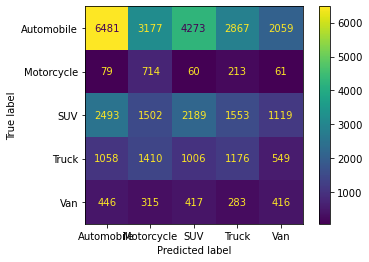

In [72]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van']).plot();

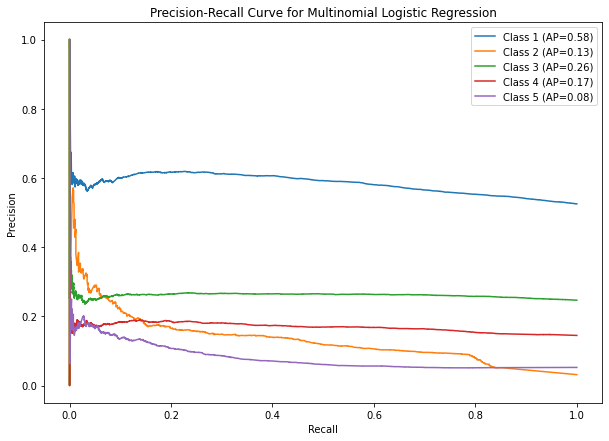

In [73]:
y_prob = rf_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van'])

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1, 6):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i-1], y_prob[:, i-1])
    average_precision[i] = average_precision_score(y_test_bin[:, i-1], y_prob[:, i-1])

# Plot the precision-recall curves
plt.figure(figsize=(10, 7))

for i in range(1, 6):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multinomial Logistic Regression')
plt.legend()
plt.show()

## Predicting Vehicle Fuel Type
- Random Forest Model

In [23]:
X = vehicles_df[['CNTTDHH', 'CDIVMSAR', 'HTPPOPDN', 'HHSIZE', 'MSASIZE', 'HHFAMINC']]
y = vehicles_df['FUELTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train);

In [25]:
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

      Diesel       0.04      0.13      0.06       650
         Gas       0.96      0.86      0.91     34247
      Hybrid       0.08      0.23      0.12      1019

    accuracy                           0.83     35916
   macro avg       0.36      0.41      0.36     35916
weighted avg       0.92      0.83      0.87     35916



In [26]:
pd.Series(y_pred).value_counts(normalize=True)

Gas       0.853157
Hybrid    0.080605
Diesel    0.066238
Name: proportion, dtype: float64

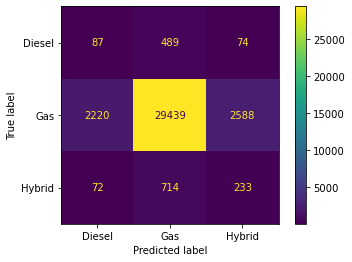

In [27]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Diesel', 'Gas', 'Hybrid']).plot();

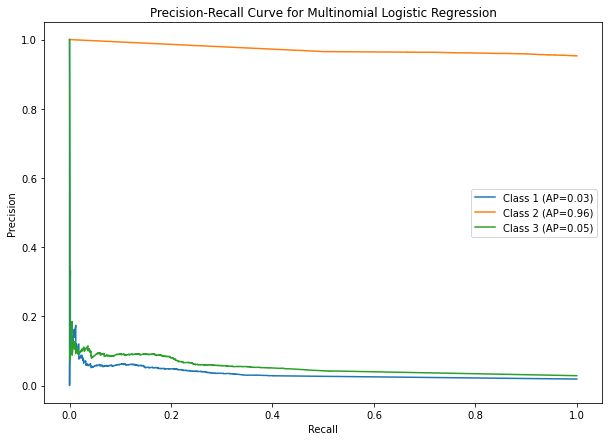

In [293]:
y_prob = rf_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=['Diesel', 'Gas', 'Hybrid'])

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1, 4):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i-1], y_prob[:, i-1])
    average_precision[i] = average_precision_score(y_test_bin[:, i-1], y_prob[:, i-1])

# Plot the precision-recall curves
plt.figure(figsize=(10, 7))

for i in range(1, 4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multinomial Logistic Regression')
plt.legend()
plt.show()

## Predicting Vehicle Age
- Multiple Linear Regression Model

In [116]:
X = vehicles_df[['CNTTDHH', 'DRVRCNT', 'HHFAMINC', 'HHSIZE', 'HHVEHCNT']]
y = vehicles_df['VEHAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [117]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train);

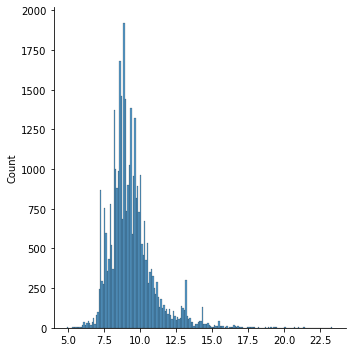

In [118]:
y_pred = lr_model.predict(X_test)
sns.displot(y_pred);

### Normalized Root Mean Squared Error
- Relative Root Mean Squared Error (RRMSE) is a variant of Root Mean Squared Error (RMSE), gauging predictive model accuracy relative to the target variable range. It normalizes RMSE by the target variable range and presents it as a percentage for easy cross-dataset or cross-variable comparison. RRMSE, a dimensionless form of RMSE, scales residuals against actual values, allowing comparison of different measurement techniques.

In [125]:
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

In [126]:
print('RRMSE:', relative_root_mean_squared_error(y_test, y_pred))

RRMSE: 0.6462012925450943
